In [ ]:
### Application: ECG-Modeling
# Work in progress

In [1]:
import numpy as np
import os, sys
import copy
sys.path.append(os.path.abspath(os.path.join('../../..')))
import tensorflow as tf
import scipy
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [3]:
current_dir = os.getcwd()
print("Current working directory: {0}".format(os.getcwd()))
os.chdir('/home/rene/BayesFlow') #Location of BayesFlow on hard drive

from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer

os.chdir(current_dir)

current_dir = os.getcwd()
print("Current working directory: {0}".format(os.getcwd()))
os.chdir('/home/rene/NeuroKit-master') #Location of BayesFlow on hard drive

from neurokit2.ecg import ecg_simulate

os.chdir(current_dir)

Current working directory: /home/rene/BayesFlow/docs/source/tutorial_notebooks
Current working directory: /home/rene/BayesFlow/docs/source/tutorial_notebooks


In [2]:
## ODE system parameters

# PQRST positions (as specified in the paper)
phi = np.pi*np.asarray([-1/3,-1/12,0,1/12,0.5])
# The original Matlab and later NeuroKit implementations use an approximation instead:
# phi = np.array([-70, -15, 0, 15, 100])/180*np.pi

# PQRST height modifiers
A = np.asarray([1.2,-5.0,30.0,-7.5, 0.75])

# PQRST width modifiers
B = np.asarray([0.25, 0.1, 0.1, 0.1, 0.4])

# Respiratory frequency
f_2 = 0.25

params_ODE = {'a': A, 'b': B, 'phi': phi, 'f_2': f_2}

## Parameters for numeric integration of ODE system

# No of samples / times t at which to integrate
Nt = 5000
# Internal sampling frequency
sf_int = 1000
# Sampling frequency of ecg
sf_ecg = 1000
# Initial value
pos_0 = np.asarray([1, 0, 0.04])
#pos_0 = np.asarray([1, 0, 0])

# Parameters of additive noise (amplitude, frequency, type)
noise_amp = 0.025 #0.025
noise_freq = 100
noise_type = 'laplace'

# Mean and standard deviation of heart rate (take precedent over number of samples if both are given)
heartrate_mean = 70
heartrate_std = 1
# In this scenario, the duration of the ecg signal or an approximate number of heartbeats must be specified
# If both are given, duration takes precedent over the approximate number of heartbeats.
duration = 10
N_heartbeats = None
# duration = None
# N_heartbeats = 50

# The dependent parameters used by the numerical method used to solve the system of ODEs
# are based around max_t, the latest time point t at which the approximate solution is computed:
# t_span is a list of the first and list t (i.e. 0 and max_t), and t_eval is an array of Nt time points
# within this range
max_t = (Nt-1)*(1/sf_int)

params_sim = {'sf_int': sf_int, 'sf_ecg': sf_ecg, 'Nt': Nt, 'max_t': max_t, \
              'pos_0': pos_0, 't_span': [0, max_t], 't_eval': np.linspace(0, max_t, Nt), \
              'noise_amplitude': noise_amp, 'noise_frequency': noise_freq, 'noise_type': noise_type, \
              'heartrate_mean': heartrate_mean, 'heartrate_std': heartrate_std, \
              'duration': duration, 'N_heartbeats': N_heartbeats}

## Parameters for time series used to model inter-heartbeat variation

# RSA (Respiratory Sinus Arrhythmia) wave
c_2 = 0.01
sigma_2 = 1

# Mayer wave
f_1 = 0.1
c_1 = 0.01
sigma_1 = (0.5* sigma_2) **0.5

# Time series scaling (via mean and standard deviation)
mean_TS = 0.1
std_TS = 0.01

params_TS = {'f_1': f_1, 'f_2': f_2, 'c_1': c_1, 'c_2': c_2, \
             'sigma_1': sigma_1, 'sigma_2': sigma_2, \
            'mean_TS': mean_TS, 'std_TS': std_TS}


print("\n Params ODE:")
print(params_ODE)
print("\n Params Time Series:")
print(params_TS)
print("\n Params simulation:")
print(params_sim)

NameError: name 'np' is not defined

In [5]:
# Helper functions
def alpha(x,y):
    return(1-((x**2 + y**2)** .5))

def delta_phi(x,y,phi):
    return(np.fmod(np.arctan2(y,x)-phi,2*np.pi))
    
def gauss_sum(x,y,a,b,phi):
    d_p = delta_phi(x,y,phi)
    gauss_summands = a*d_p*np.exp(-0.5*((d_p/b)**2))
    return(-np.sum(gauss_summands))


In [3]:
## Implementation of the system of ODEs used in the model

# Helper functions
def alpha(x,y):
    return(1-((x**2 + y**2)** .5))

def delta_phi(x,y,phi):
    return(np.fmod(np.arctan2(y,x)-phi,2*np.pi))
    
def gauss_sum(x,y,a,b,phi):
    d_p = delta_phi(x,y,phi)
    gauss_summands = a*d_p*np.exp(-0.5*((d_p/b)**2))
    return(-np.sum(gauss_summands))

# Note that the paper specifies A = 0.15, but this distorts the entire signal
# rather than just creating baseline wander.
def z_0(t,f_2, A=0.005):
    return(A*np.sin(2*np.pi*f_2*t))

def omega(t, T, max_t, Nt):
    t_index = int((t/max_t*Nt)-1)
    return(T[t_index])

# Actual system of ODEs
def ECG_model(t, p, T, params_ODE, params_sim, baseline_wander=False, z_zero=None, omega=None):
    alpha_yx = alpha(p[0],p[1])
    omega_T = omega(t, T, params_sim['max_t'], params_sim['Nt'])
    
    position = [alpha_yx*p[0]-omega_T*p[1], alpha_yx*p[1]+omega_T*p[0], \
                gauss_sum(p[0],p[1],params_ODE['a'],params_ODE['b'],params_ODE['phi']) \
                - p[2]+z_zero(t,params_ODE['f_2'])]
    
    return(position)

## Functions used to rescale the parameters depending on the inputs given

# If a mean heartrate is specified, the PQRS locations and widths have to be adapted.
def rescale_ODE_params(params_ODE, heartrate_mean):
    hr_fact = (heartrate_mean/60)**0.5
    hr_fact2 = hr_fact**0.5
    
    params_ODE_rescaled = copy.deepcopy(params_ODE)
    params_ODE_rescaled['phi'] *= np.array([hr_fact2, hr_fact, 1, hr_fact, hr_fact2])
    params_ODE_rescaled['b'] *= hr_fact
    return(params_ODE_rescaled)

# In conjunction with the mean heartrate, either a desired duration or
# an approximate number of desired heartbeats (N_heartbeats) must be specified. 
# The unknown quantity is computed from the one given (e.g. unknown N_heartbeats from known duration)
def rescale_simulation_params(params_sim, heartrate_mean):
    d = params_sim['duration']
    N = params_sim['N_heartbeats']
    
    params_sim_rescaled = copy.deepcopy(params_sim)
    
    if d is not None:    
        # Determine approximate number of heartbeats
        N = int(np.round(params_sim['duration'] * (heartrate_mean / 60)))
    else:
        if N is None:
            print("Please specify either a duration or an approximate number of heartbeats.")
        else:
            # Determine duration
            d = N*60/heartrate_mean
            params_sim_rescaled['duration'] = d
             
    # Determine number of samples needed and latest time point
    sf_int = params_sim['sf_int']
    Nt = int(N*sf_int)
    max_t = (Nt-1)*(1/sf_int)
    
    params_sim_rescaled['Nt'] = Nt
    params_sim_rescaled['max_t'] = max_t
    params_sim_rescaled['t_eval'] = np.linspace(0,max_t,Nt)
    params_sim_rescaled['t_span'] = [0, max_t]
    
    return(params_sim_rescaled)

# Handles the logic behind rescaling the parameters (rescaling occurs if a mean heartrate is given)
def rescale_if_needed(params_ODE, params_sim):
    hr_mean = params_sim['heartrate_mean']
    if hr_mean is not None:
        # Rescale location and width of PQRST signals to match mean heart rate
        params_ODE_r = rescale_ODE_params(params_ODE, hr_mean)
        # Rescale simulation parameters (time points for evaluation etc) to match mean heart rate
        params_sim_r = rescale_simulation_params(params_sim, hr_mean)
    else:
        params_ODE_r = params_ODE
        params_sim_r = params_sim
    return params_ODE_r, params_sim_r

## Functions used to downsample should the target ecg sampling frequency (sf_ecg) not correspond
## to the internal sampling frequency (sf_int)

# q is the ratio between the internal and the ecg sampling rate.
def get_downsampling_stepsize(params_sim):
    sf_int = params_sim['sf_int']
    sf_ecg = params_sim['sf_ecg']
    q = np.round(sf_int/sf_ecg)
    qd = sf_int/sf_ecg
    if q != qd:
        raise ValueError(
            "Internal sampling frequency (sfint) must be an integer multiple of the ECG sampling frequency"
            " (sfecg). Your current choices are: sfecg = "
            + str(sf_ecg)
            + " and sfint = "
            + str(sf_int)
            + "."
        )
    return(int(q))

# Handles the logic behind downsampling (downsampling occurs if q is greater than one)
def downsample_if_needed(q, x_int, y_int, z_int):
    # Downsample the signal to sf_ecg (via q = round(sf_int/sf_ecg) )
    if q != 1:
        x = x_int[np.arange(0, len(x_int), step=q).astype(int)]
        y = y_int[np.arange(0, len(y_int), step=q).astype(int)]
        z = z_int[np.arange(0, len(z_int), step=q).astype(int)]
    else:
        x = x_int
        y = y_int
        z = z_int
    return(x,y,z)

## Post-processing of the ecg signal

# Rescale signal to the range (target_min, target_max)
def rescale_signal(z, target_min, target_max):
    zmin = np.min(z)
    zmax = np.max(z)
    z = (z - zmin) * (target_max-target_min) / (zmax - zmin) + target_min
    return(z)

# Add additive noise to the signal (typically with a frequency below the sampling frequency)
def add_distortion(signal, noise_amplitude, noise_frequency=100, signal_sampling_rate=1000, \
                   noise_type="laplace", random_state=42):
    #For reproducibility  
    np.random.seed(random_state)
    
    n_samples = len(signal)
    signal_sd = np.std(signal, ddof=1)
    
    if signal_sd != 0:
        noise_amplitude *= signal_sd
    
    noise = np.zeros(n_samples)
    duration = n_samples / signal_sampling_rate
    # Apply a very conservative Nyquist criterion in order to ensure
    # sufficiently sampled signals.
    nyquist = signal_sampling_rate * 0.1
    if noise_frequency > nyquist:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since it cannot be resolved at "
                f" the sampling rate of {signal_sampling_rate} Hz. Please increase "
                f" sampling rate to {noise_frequency * 10} Hz or choose "
                f" frequencies smaller than or equal to {nyquist} Hz.",
                category=NeuroKitWarning,
            )
        return noise
    # Also make sure that at least one period of the frequency can be
    # captured over the duration of the signal.

    if (1 / noise_frequency) > duration:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since its period of {1 / noise_frequency} "
                f" seconds exceeds the signal duration of {duration} seconds. "
                f" Please choose noise frequencies larger than "
                f" {1 / duration} Hz or increase the duration of the "
                f" signal above {1 / noise_frequency} seconds.",
                category=NeuroKitWarning,
            )
        return noise

    noise_duration = int(duration * noise_frequency)

    if noise_type.find('aplace') != -1 or noise_type.find('efault') != -1:
        noise = np.random.laplace(0, noise_amplitude, noise_duration)
    elif noise_type.find('aussian') != -1 or noise_type.find('ormal') != -1:
        noise = np.random.normal(0, noise_amplitude, noise_duration)
    elif noise_type.find('niform') != -1:
        bound = noise_amplitude/2
        noise = np.random.uniform(bound,-bound, noise_duration)
    
    # Resample via interpolation
    n_noise = len(noise)
    if n_noise != n_samples:
        # Use third order splines to interpolate
        noise = scipy.ndimage.zoom(noise, n_samples / n_noise)
    
    return signal+noise

## Generating the simulated ecg

def generate_ECG(params_ODE, params_sim, params_TS, baseline_wander=False):
    params_ODE_r, params_sim_r = rescale_if_needed(params_ODE, params_sim)
    
    if params_TS is not None:
        T = generate_time_series(params_TS, params_sim)
        om = omega
    else:
        T = 0
        om = lambda t, T, max_t, Nt: 2*np.pi
    
    if baseline_wander:
        z_zero = z_0
    else:
        z_zero = lambda t, f_2: 0
        
    x_int, y_int, z_int = scipy.integrate.solve_ivp(lambda t, y: \
                                                    ECG_model(t, y, T, params_ODE_r, params_sim_r, \
                                                              baseline_wander, z_zero, om), \
                                                    params_sim_r['t_span'], params_sim['pos_0'], \
                                                    t_eval=params_sim_r['t_eval']).y
    
    q = get_downsampling_stepsize(params_sim)
    x, y, z = downsample_if_needed(q, x_int, y_int, z_int)
    
    z = rescale_signal(z,-0.4,1.2)

    if params_sim['noise_type'] is not None:
        z = add_distortion(z, params_sim['noise_amplitude'], noise_type=params_sim['noise_type'], \
                          signal_sampling_rate= params_sim['sf_int'])  
    
    return(x,y,z)

# def add_noise(noisefree_ecg, noise_amplitude=None, noise_type='uniform'):
#     if noise_amplitude is None:
#         noise_amplitude = 0.025
    
#     n = len(noisefree_ecg)
#     ecg_std = np.std(noisefree_ecg)
    
#     if ecg_std != 0:
#         noise_amplitude *= ecg_std
    
#     if noise_type.find('aussian') != -1 or noise_type.find('ormal') != -1:
#         noise = np.random.normal(0, noise_amplitude, n)
#     elif noise_type.find('niform') != -1 or noise_type.find('efault') != -1:
#         h = noise_amplitude/2
#         l = -noise_amplitude/2
#         noise = np.random.uniform(h, l, n)
#     elif noise_type.find('aplace') != -1:
#         noise = np.random.laplace(0, noise_amplitude, n)
#     else:
#         print("{} is not a valid noise type.".format(noise_type))
#         print("Possible noise distributions are: gaussian (i.e. normal), uniform and laplace")
#         return None
        
#     return(noisefree_ecg+noise)




In [11]:
xdata, ydata, zdata = generate_ECG(params_ODE, params_sim, params_TS = None, baseline_wander=True)

<IPython.core.display.Javascript object>


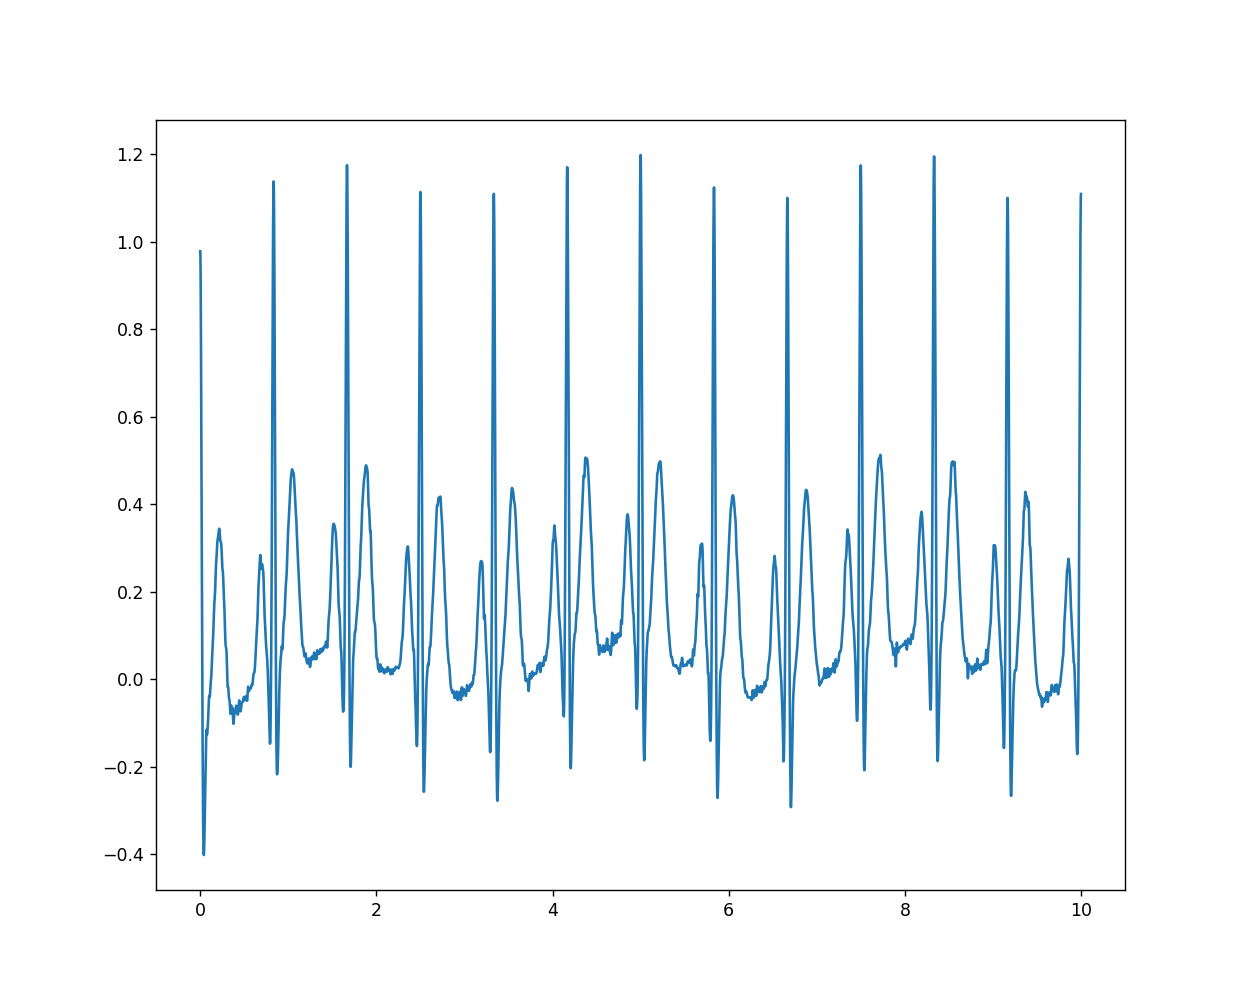

In [12]:
%matplotlib notebook
fig_2d = plt.figure(figsize=(10,8))
ax_2d = plt.axes()

m = len(zdata)

ax_2d.plot(np.arange(m)*duration/m, zdata)


In [50]:
def generate_ecg_parameter_prior(size, params_ODE, params_sim, deviation_mean=0.05, deviation_std=1,\
                   ODE_params_to_vary=['b','phi','f_2'], sim_params_to_vary=[]):
    
    output_ODE = {}
    output_sim = {}
    
    for p in ODE_params_to_vary:
        original_p = params_ODE[p]
        variation_coefficients = np.random.normal(deviation_mean, deviation_std, size)
        output_p = np.tile(original_p, (size,1))
        output_p += variation_coefficients[:, np.newaxis]
        output_ODE[p] = output_p
    
    for p in sim_params_to_vary:
        original_p = params_sim[p]
        
        if isinstance(original_p, int):
            original_p = float(original_p)     
            variation_coefficients = np.random.normal(deviation_mean, deviation_std, size)
            output_p = np.tile(original_p, (size,1))
            output_p += variation_coefficients[:, np.newaxis]
            output_p = np.asarray([int(output_p[i]) for i in range(len(output_p))])
        else:
            variation_coefficients = np.random.normal(deviation_mean, deviation_std, size)
            output_p = np.tile(original_p, (size,1))
            output_p += variation_coefficients[:, np.newaxis]
            
        output_sim[p] = output_p
    
    return(output_ODE, output_sim)

In [51]:
out_ODE, out_sim = generate_ecg_parameter_prior(100, params_ODE, params_sim, \
                                                 sim_params_to_vary=['Nt', 'pos_0'])

In [ ]:
## Offene Fragen
# 1. Welche Parameter sollten variiert werdden (b,phi,a,f_2, Simulation)?
# 2. Wie sollte variiert werden (Verteilung, Streuung)?
# Ziel: Zunächst einmal gesunde Fälle priorisieren. Ggf. mehrere Modelle nutzen (unterschiedliche Pathologien)
# -> Model selection
# Einheit für Periode gleich halten (gleiche Zeitschrittgröße); Signallänge (/Anzahl der Perioden)
# erstmal fix mit CNN, dann mit LSTM variabel

# Weiß man, wie hoch die Rauschamplitude ist? Wenn ja -

# Kalibrierungsproblemerklärung: zu wenig trainiert, zu kleines Netz